In [34]:
!pip install -q kagglehub numpy pandas networkx networkx-temporal networkx-temporal[draw] matplotlib

In [1]:
import kagglehub
import kagglehub.datasets
import numpy as np
import pandas as pd
import networkx as nx
import networkx_temporal as tx
from os.path import join as join_path
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

# Download Dataset

In [2]:
dataset_path = kagglehub.dataset_download("dgawlik/nyse")

In [3]:
fundamentals_pd = pd.read_csv(join_path(dataset_path,"fundamentals.csv"))
prices_pd = pd.read_csv(join_path(dataset_path, "prices.csv"))
prices_split_adjusted_pd = pd.read_csv(join_path(dataset_path, "prices-split-adjusted.csv"))
securities_pd = pd.read_csv(join_path(dataset_path, "securities.csv"))

In [4]:
all_symbols = prices_pd['symbol'].unique()

In [6]:
prices_pd['date'] = pd.to_datetime(prices_pd['date'], format='mixed').dt.date
dates = prices_pd['date'].sort_values().unique()

def date_to_int(date):
    if not isinstance(date, pd._libs.tslibs.timestamps.Timestamp):
        date = pd.to_datetime(date, format='mixed').date()
    return dates.tolist().index(date)

def int_to_date(idx):
    return dates[idx]

print(dates)
print(int_to_date(0))
print(date_to_int(int_to_date(len(dates)-1)))

[datetime.date(2010, 1, 4) datetime.date(2010, 1, 5)
 datetime.date(2010, 1, 6) ... datetime.date(2016, 12, 28)
 datetime.date(2016, 12, 29) datetime.date(2016, 12, 30)]
2010-01-04
1761


In [54]:
def add_features(target_prices_df = prices_pd):
    target_prices_df['day_diff'] = ((target_prices_df['close']) - (o:=target_prices_df['open'])) / o
    # target_prices_df['close_1d'] = target_prices_df['close'].pct_change(1)
    # target_prices_df['close_3d'] = target_prices_df['close'].pct_change(3)


def similarity_score(record1: pd.Series, record2: pd.Series, thresh = 1, norm_factor = 1e-5) -> float:
    if record1['symbol'] == record2['symbol']:
        return 0
    
    abs_diff = abs((record2['day_diff'])-(record1['day_diff'])) + norm_factor
    w = -np.log(abs_diff)
    if w > thresh:
        return w
    else:
        return 0
        

def build_temporal_graphs(target_prices_df: pd.DataFrame, similarity_score = similarity_score ):
    add_features(target_prices_df)
    target_prices_df.fillna(0, inplace=True)

    for date, group in target_prices_df.groupby('date'):
        group.reset_index(inplace=True)
        graph = nx.Graph()
        dateIdx = date_to_int(date)
        for _, record1 in group.iterrows():
            group['sim_score'] = group.apply(lambda record2: similarity_score(record1, record2), axis=1)

            edges = group[group['sim_score'] > 0]
            
            for j, edge_row in edges.iterrows():
                graph.add_edge(record1['symbol'], edge_row['symbol'], weight=edge_row['sim_score'], time=dateIdx)

        yield dateIdx, date, graph


In [52]:
def show_graph(G):
    pos = nx.spring_layout(G, dim=2)
    nx.draw(G,pos, with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=10)
    plt.show()

  0%|          | 0/1762 [00:00<?, ?it/s]/tmp/ipykernel_69483/3034520917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_prices_df['open_close'] = ((target_prices_df['close']) - (o:=target_prices_df['open'])) / o
/tmp/ipykernel_69483/3034520917.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_prices_df['close_1d'] = target_prices_df['close'].pct_change(1)
/tmp/ipykernel_69483/3034520917.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

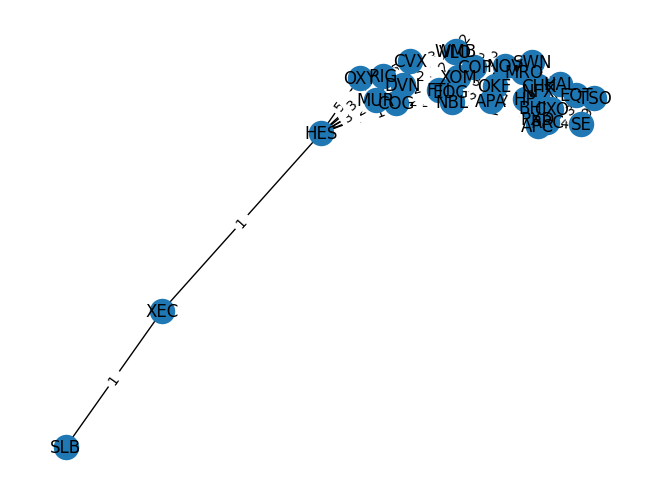

  6%|▌         | 101/1762 [00:16<04:10,  6.64it/s]

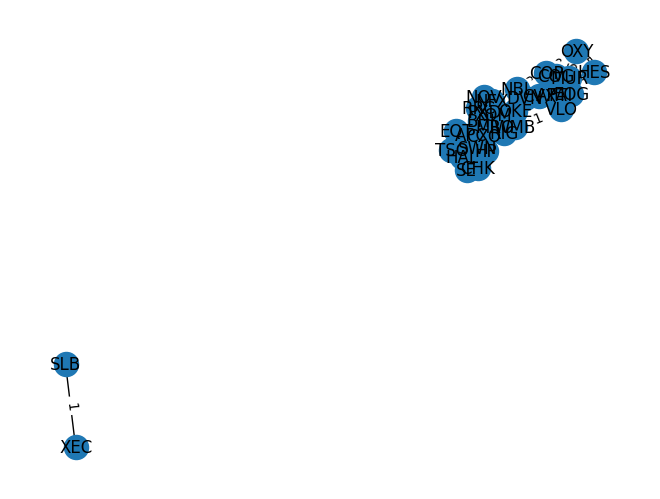

 11%|█▏        | 201/1762 [00:31<03:10,  8.20it/s]

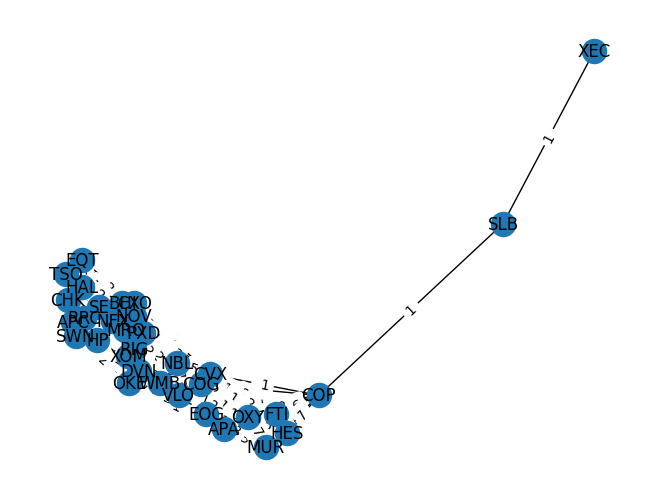

 17%|█▋        | 301/1762 [00:45<02:59,  8.14it/s]

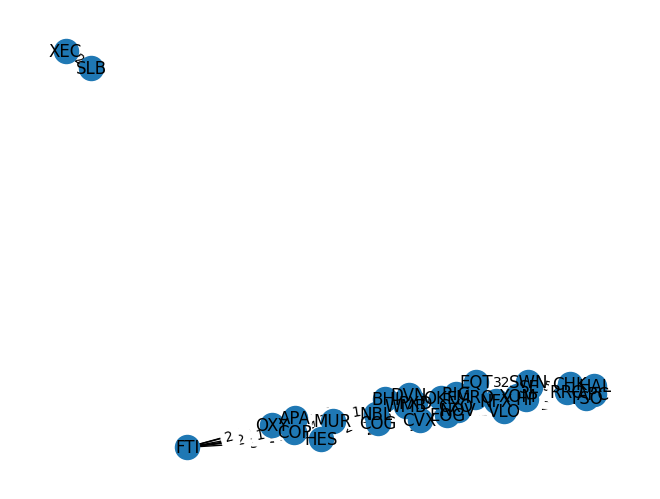

 23%|██▎       | 401/1762 [01:01<02:48,  8.09it/s]

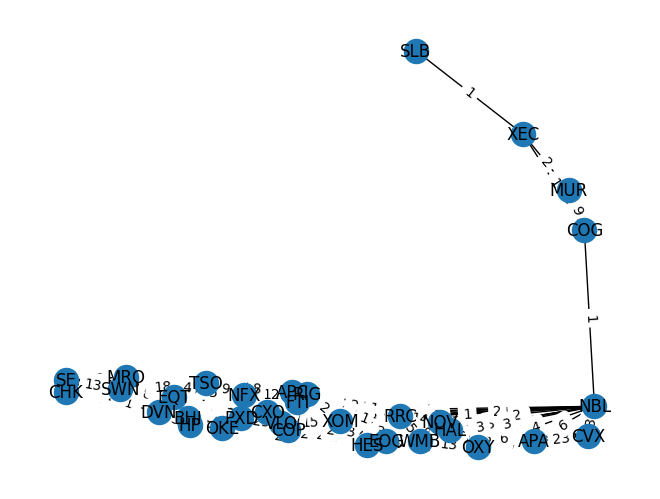

 28%|██▊       | 501/1762 [01:15<02:32,  8.25it/s]

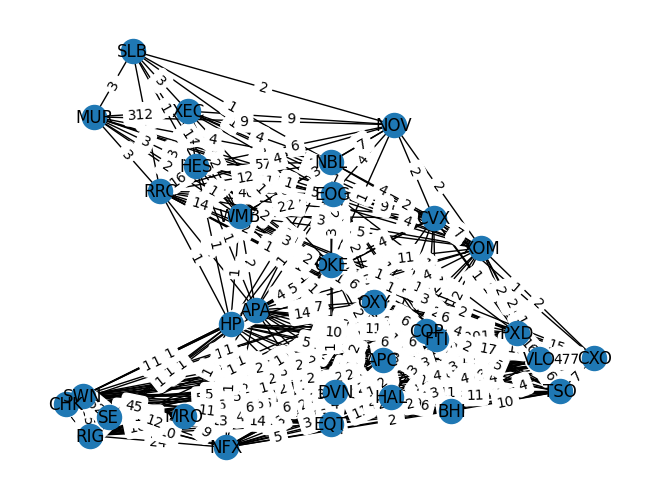

 34%|███▍      | 601/1762 [01:31<02:15,  8.55it/s]

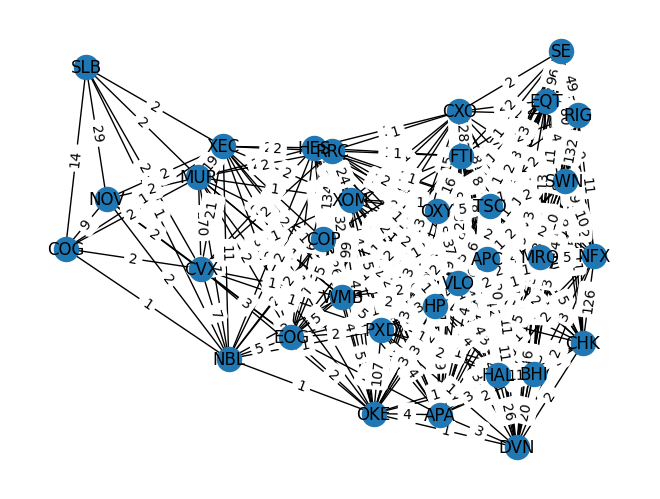

 40%|███▉      | 701/1762 [01:45<02:19,  7.58it/s]

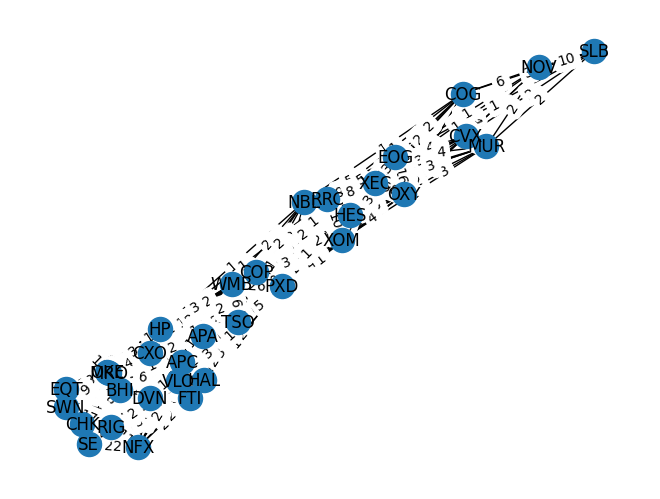

 45%|████▌     | 801/1762 [02:01<02:31,  6.36it/s]

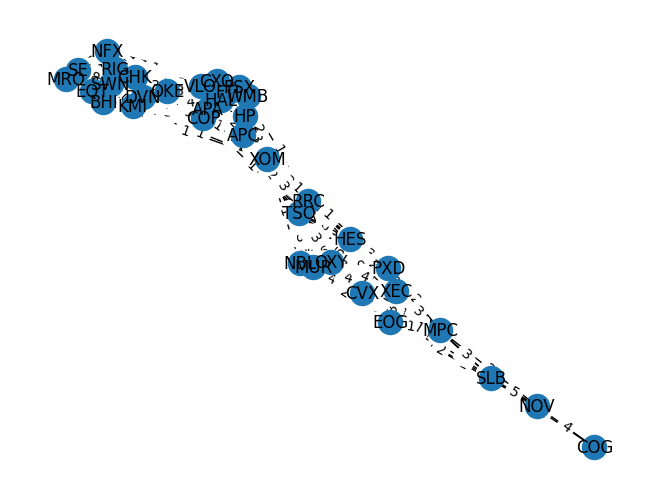

 51%|█████     | 901/1762 [02:18<02:09,  6.67it/s]

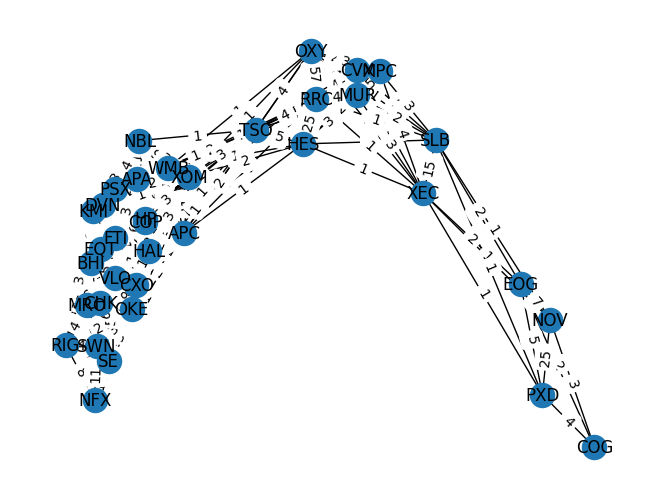

 51%|█████▏    | 906/1762 [02:22<05:00,  2.85it/s]

KeyboardInterrupt: 

In [53]:
energies = (securities_pd[securities_pd['GICS Sector'] == 'Energy']['Ticker symbol'].to_list())    
energies10_graphs = build_graph(prices_pd[prices_pd['symbol'].isin(energies)])

pbar = tqdm(range(len(dates)))
for dateIdx, date, graph in energies10_graphs:
    pbar.update(1)
    if dateIdx % 100 == 0:
        show_graph(graph)